In [1]:
import math
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque

## Creating the environment

In [2]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

C:\Users\Lau\miniconda3\envs\rlProjects3.7\lib\site-packages\gym\envs\registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
C:\Users\Lau\miniconda3\envs\rlProjects3.7\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\Lau\miniconda3\envs\rlProjects3.7\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=Tru

## Creating the neural network

In [3]:
class QNet(nn.Module):
    def __init__(self, action_num=2, hidden_size=256):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(4, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_num)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

## Creating the replay buffer

In [4]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, mini_batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.mini_batch_size = mini_batch_size
        self.reset()

    def reset(self):
        # create a deque for each data type with set max length
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def buffer_full(self):
        return len(self.data_dict[self.data_keys[0]]) == self.buffer_size

    def data_log(self, data_name, data):
        # split tensor along batch into a list of individual datapoints
        data = data.cpu().split(1)
        
        # extend the deque for data type, deque will handle popping old data to maintain buffer size
        self.data_dict[data_name].extend(data)

    def __iter__(self):
        # length of the data_dict
        batch_size = len(self.data_dict[self.data_keys[0]])
        
        # if that length is not divisible by mini_batch_size, subtract from it until it is
        batch_size = batch_size - batch_size % self.mini_batch_size

        # create batch_size number of ids and shuffle them
        ids = np.random.permutation(batch_size)
        
        # split the ids into mini batches
        ids = np.split(ids, batch_size // self.mini_batch_size)
        
        # for every id in every batch, make a batch_dict out of it (looks like data_dict)
        # and return it as a generator
        for i in range(len(ids)):
            batch_dict = {}
            for name in self.data_keys:
                c = [self.data_dict[name][j] for j in ids[i]]
                batch_dict[name] = torch.cat(c)
            batch_dict["batch_size"] = len(ids[i])
            yield batch_dict

    def __len__(self):
        return len(self.data_dict[self.data_keys[0]])

## Testing the agent -> used for plotting the mean values

In [5]:
def test_agent():
    done = False
    total_reward = 0
    observation = torch.FloatTensor(env.reset()).unsqueeze(0)

    with torch.no_grad():
        while not done:
            # getting the q-values
            q_values = q_net(observation)
            
            # getting the most optimal q-value  
            action = q_values.argmax().cpu().item()
            
            # step
            observation, reward, done, info = env.step(action)
            
            # transform next observation into a tensor
            observation = torch.FloatTensor(observation).unsqueeze(0)
            
            # collect reward
            total_reward += reward

    return total_reward

## Training the neural network

In [6]:
def dqn_update():
    for data_batch in replay_buffer:
        next_q_values = q_net(data_batch["next_states"]).detach()
        q_values = q_net(data_batch["states"])

        index_q_values = q_values.gather(1, data_batch["actions"])
        max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)
        expected_q_value = data_batch["rewards"] + GAMMA * max_next_q_values * data_batch["masks"]

        q_loss = (index_q_values - expected_q_value).pow(2).mean()

        optimizer.zero_grad()
        q_loss.backward()
        optimizer.step()

## Main

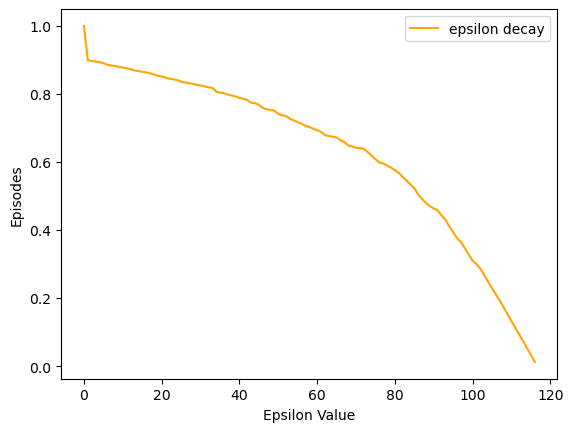

In [7]:
LR = 1e-2
GAMMA = 0.99
BUFFER_SIZE = 2000
MINI_BATCH_SIZE = 32
MAX_STEPS = 20000
DATA_NAMES = ["states", "next_states", "actions", "rewards", "masks"]
ROLLOUTS = 0
STEP = 0
EPSILON = 1
SCORE_LOGGER = []
epsilon_values = []

# initialize NN, optimizer and replay buffer
q_net = QNet()
optimizer = optim.Adam(q_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(DATA_NAMES, BUFFER_SIZE, MINI_BATCH_SIZE)

while STEP < MAX_STEPS:
    observation = torch.FloatTensor(env.reset()).unsqueeze(0)
    done = False

    states = []
    rewards = []
    actions = []
    masks = []
    while not done:
        states.append(observation)

        # take most optimal action
        if random.random() > EPSILON:
            q_values = q_net(observation)
            action = q_values.argmax().reshape(-1, 1)
        # take random action
        else:
            action = torch.LongTensor([env.action_space.sample()]).reshape(-1, 1)

        # step
        observation, reward, done, info = env.step(action.cpu().item())

        # transforming reward into a tensor
        reward = torch.FloatTensor([reward]).unsqueeze(0)
        
        rewards.append(reward)
        actions.append(action)
        masks.append(torch.FloatTensor([1 - done]).unsqueeze(0))

        # transforming observation into a tensor
        observation = torch.FloatTensor(observation).unsqueeze(0)
        STEP += 1

    states.append(observation)
    
    # append to the replay buffer
    replay_buffer.data_log("states", torch.cat(states[:-1]))
    replay_buffer.data_log("next_states", torch.cat(states[1:]))
    replay_buffer.data_log("rewards", torch.cat(rewards))
    replay_buffer.data_log("actions", torch.cat(actions))
    replay_buffer.data_log("masks", torch.cat(masks))
    
    # if the buffer is full -> flush
    if replay_buffer.buffer_full():
        dqn_update()

        if ROLLOUTS % 2 == 0:
            new_lr = max(1e-4, ((MAX_STEPS - STEP) / MAX_STEPS) * LR)
            epsilon_values.append(EPSILON)
            EPSILON = max(0, ((MAX_STEPS - STEP) / MAX_STEPS) * 1)
                    
            # log scores from the simulation
            SCORE_LOGGER.append(np.mean([test_agent() for _ in range(25)]))

            # update adam lr
            optimizer.param_groups[0]["lr"] = new_lr
            
    ROLLOUTS += 1

env.close()
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(SCORE_LOGGER, color="orange", label="learning rate")
plt.legend(loc="lower right")
plt.savefig("resources\\learning_curve.png")

plt.clf()
plt.xlabel("Epsilon Value")
plt.ylabel("Episodes")
plt.plot(epsilon_values, color="orange", label="epsilon decay")
plt.legend(loc="upper right")
plt.savefig("resources\\epsilon_decay.png")